In [1]:
## load the packages

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import subprocess
import os
from   shapely.geometry import Point

In [3]:
# inputs
path_out = '/home/shg096/scratch/test/domain/'
pfafs = ['71'] # 71 Saskatchewan, 78 Colombia, 82 McKenzie;
# pfafs = ['71','78'] # reading multiple files
station_to_seg_file = '../../data/station_seg_merit/station_seg_merit_test.csv'

In [4]:
# # project path
# riv_path = '/project/rpp-kshook/Model_Output/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
# cat_path = '/project/rpp-kshook/Model_Output/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
# cst_path = '/project/rpp-kshook/Model_Output/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/coastal_hillslopes/'

# temporary paths
riv_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cat_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cst_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/coastal_hillslopes/'

# pattern
riv_file_template = 'riv_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cat_file_template = 'cat_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cst_file_template = 'hillslope_*_clean.shp'

In [5]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

## Load and append the pfaf

In [6]:
riv, cat = gm.merit_read_file (pfafs,
                               riv_path,
                               riv_file_template,
                               cat_path,
                               cat_file_template,
                               path_cst = cst_path,
                               cst_file_template = cst_file_template)

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


## prepare the network topology

In [7]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                            cat=cat,\
                            cat_cols={'id':'COMID', 'hillslope':'hillslope', 'area' :'unitarea'},\
                            network = 'merit')

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:491: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['latitude'] = cat.centroid.y
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:492: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['longitude'] = cat.centroid.x


## Domain selection

In [8]:
# # Create a DataFrame from the dictionary
# data = {
#     'Station ID': ['05BE004', '05BH004', '05BL004', '05CC002'],
#     'seg ID': [71028039, 71027942, 71034975, 71022153],
#     'Station name': [
#         'BOW RIVER NEAR SEEBE',
#         'BOW RIVER AT CALGARY',
#         'HIGHWOOD RIVER BELOW LITTLE BOW CANAL',
#         'RED DEER RIVER AT RED DEER'
#     ],
#     'up': [0, 0, 0, 0],
#     'X': [-115.03,-114.05,-113.86,-113.82],
#     'Y': [51.11,    51.05,  50.58,  52.27]
# }
# stations_seg_id = pd.DataFrame(data) # or the data can come from a csv file


# Or load from the file
stations_seg_id = pd.read_csv(station_to_seg_file)

#
stations_seg_id = stations_seg_id.sort_values(by='seg ID').reset_index(drop=True) # order
stations_seg_id = stations_seg_id[stations_seg_id['seg ID'].isin(cat['COMID'])].reset_index(drop=True) # get only station in the domain

# add ups from the riv merit to station_seg_id
riv_temp = riv.copy()
riv_temp = riv_temp[riv_temp['COMID'].isin(stations_seg_id['seg ID'])]
riv_temp = riv_temp.sort_values(by='COMID').reset_index(drop=True)
stations_seg_id ['maxup'] = riv_temp['maxup']
stations_seg_id ['up1'] = riv_temp['up1']
stations_seg_id ['up2'] = riv_temp['up2']
stations_seg_id ['up3'] = riv_temp['up3']
stations_seg_id ['up4'] = riv_temp['up4']

# Create a points from the dictionary
geometry = [Point(xy) for xy in zip(stations_seg_id['X'], stations_seg_id['Y'])]
stations_points = gpd.GeoDataFrame(stations_seg_id, geometry=geometry, crs='EPSG:4326')

In [9]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'COMID'},\
                                       riv=riv,\
                                       riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                       outlet_id=list(stations_seg_id['seg ID']))

# create the ntopo from cat_slice, riv_slice
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'merit')

<AxesSubplot:>

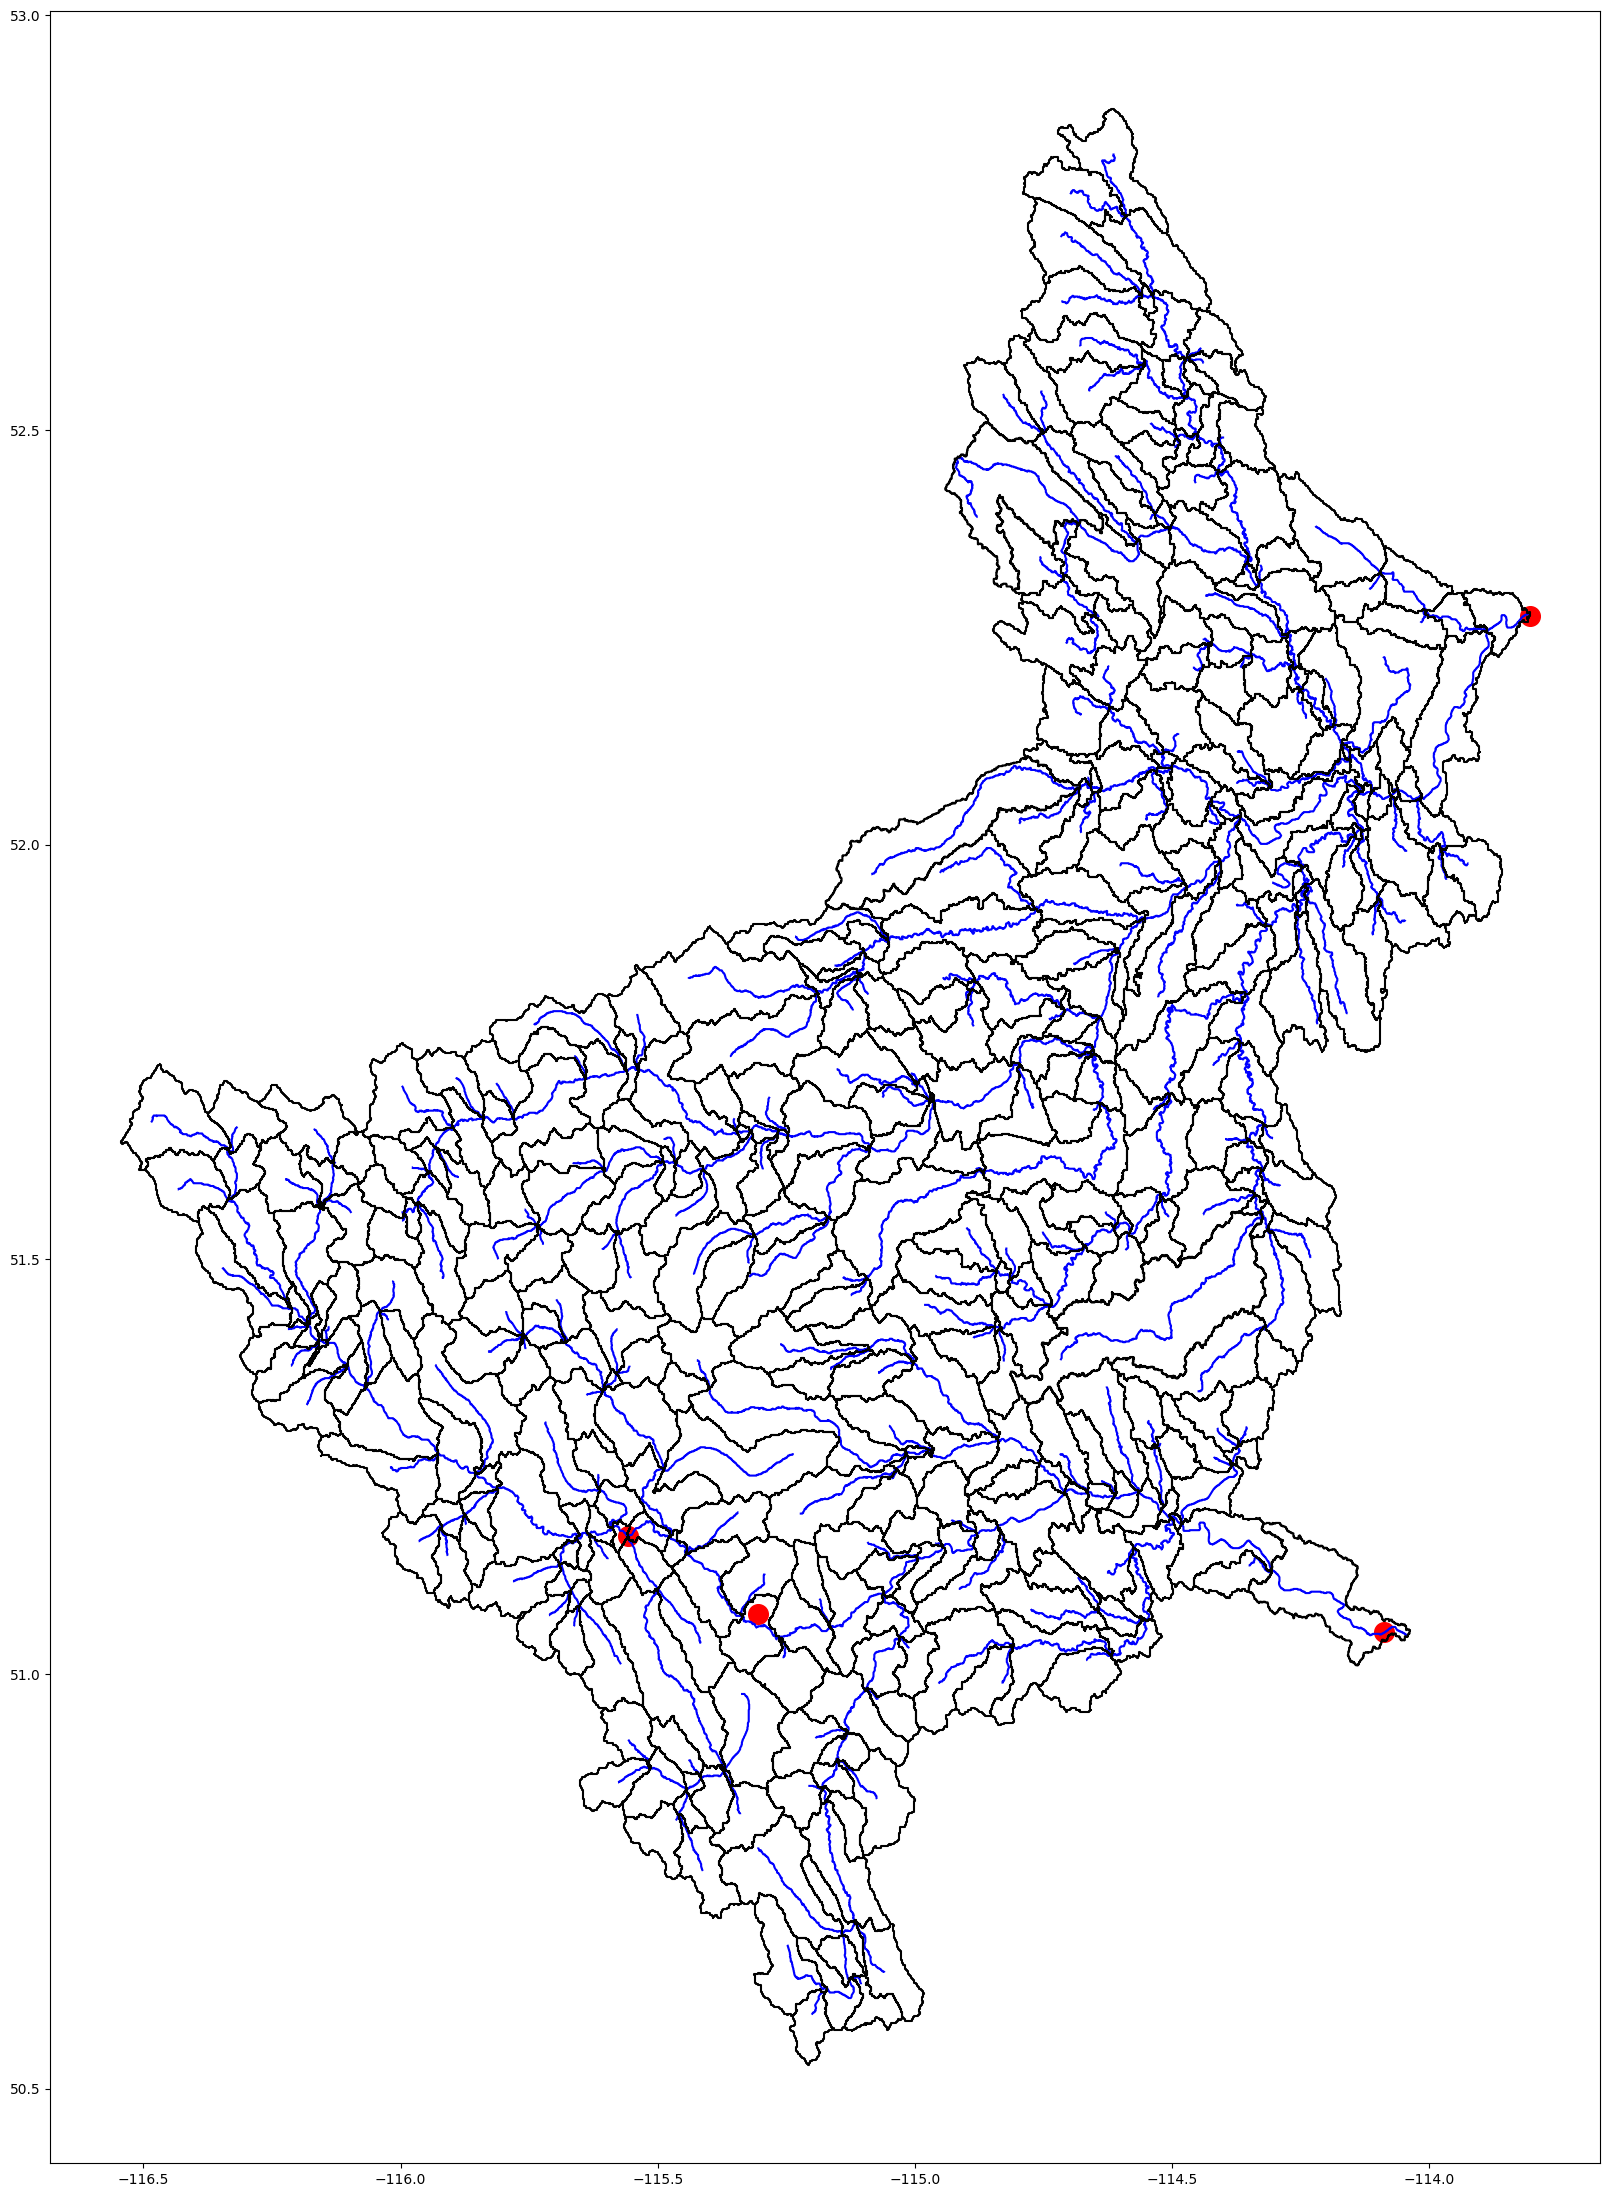

In [10]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_points.plot(ax=ax, color='r', markersize=200)

In [11]:
cat_slice.to_file(path_out+'domain_cat.shp')
riv_slice.to_file(path_out+'domain_riv.shp')
xr_ntopo.to_netcdf(path_out+'domain_ntopo.nc')
stations_seg_id.to_csv(path_out+'domain_station_segment.csv')